<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/lessons/machine_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer látás betanított modellek alapján

**Megjegyzés**

Kérjük kapcsolja be a GPU támogatást a Colab virtuális gépen. Válassza a  menüből az
**Edit/Notebook settings** és válassza a T4 GPU-t. Ezután a következő kódblokknak a *Tesla T4* szöveget kell kiírnia.

In [1]:
!nvidia-smi -q -i 0 | grep "Product Name"

    Product Name                          : Tesla T4


## Kép osztályozás

A mesterséges intelligencia, gépi tanulás és neurális hálózatok segítségével egyre jobb modelleket dolgoznak ki a képek osztályozására.
A megoldandó feladat, hogy egy eddig nem látott képet "megmutatva" a modell felhasználásával a számítógép mondja meg, ogy mi van a képen. Számos kész, szabadon letölthető, már betanított modell is rendelkezésünkre áll.

Először a DenseNet-Caffe modellt (Densely Connected Convolutional Networks - https://arxiv.org/abs/1608.06993) használjuk az ImageNet Large Scale Visual Recognition Challenge 2012 (ILSVRC2012) versenyéről. 1000 osztály megkülönböztetésére tanították meg a modellt



In [2]:
import requests
import imutils
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL

Először töltsük le a betanított *caffe* modelt.



In [3]:
!wget -q -O sample_data/classification_classes_ILSVRC2012.txt https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/classification_classes_ILSVRC2012.txt
!wget -q -O sample_data/DenseNet_121.caffemodel https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/DenseNet_121.caffemodel
!wget -q -O sample_data/DenseNet_121.prototxt https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/DenseNet_121.prototxt

Töltsük be a letöltött modellt.

In [4]:
# ImageNet osztály nevek
with open('sample_data/classification_classes_ILSVRC2012.txt', 'r') as f:
   class_names = f.read().split('\n')
model = cv2.dnn.readNet(model='sample_data/DenseNet_121.caffemodel',
                        config='sample_data/DenseNet_121.prototxt',
                        framework='Caffe')
print(class_names[:20])

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark', 'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock', 'hen', 'ostrich, Struthio camelus', 'brambling, Fringilla montifringilla', 'goldfinch, Carduelis carduelis', 'house finch, linnet, Carpodacus mexicanus', 'junco, snowbird', 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 'robin, American robin, Turdus migratorius', 'bulbul', 'jay', 'magpie', 'chickadee']


Egy Python függvényt készítünk egy kép osztályozásához. We create a function to use the model for an image. During the pre-processing image is scaled down and mean is sustracted.

In [5]:
def classify_img(image):
    """ kép osztályozás caffe modellel """
    # blob készítése a képböl 224 x 224 méretre csökkentés
    blob = cv2.dnn.blobFromImage(image=image, scalefactor=0.01, size=(224, 224),
                                 mean=(104, 117, 123))
    model.setInput(blob)        # bemenet beállítása a neurális hálózathoz

    outputs = model.forward()   # kép átküldése a neurális hálón
    final_outputs = outputs[0]
    final_outputs = final_outputs.reshape(1000, 1)  # 1D többé konvertálás

    label_id = np.argmax(final_outputs) # legnagyobb valószínűségű osztály indexe
    # convert the output scores to softmax probabilities
    probs = np.exp(final_outputs) / np.sum(np.exp(final_outputs))
    final_prob = np.max(probs)      # legnagyobb valószínűség értéke
    out_name = class_names[label_id]
    out_text = f"{out_name}, {final_prob:.1%}"
    fig, ax = plt.subplots(1, 1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.set_title(out_text)
    ax.axis('off')

Egy minta kép letöltése a BME épületek közötti átjáróról.

In [6]:
!wget -q -O sample_data/sh1.jpg https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/sh1.jpg

A modell szerint egy kolortort ábrázol a kép.

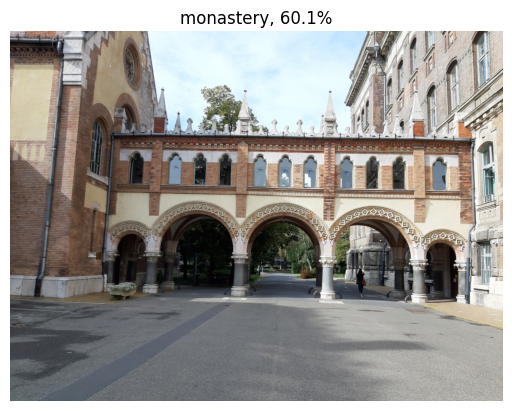

In [7]:
img1 = cv2.imread('sample_data/sh1.jpg')
classify_img(img1)

Az alábbi *urls* listát kibővíthetjük, felülírhatjuk az interneten található képek linkjével.

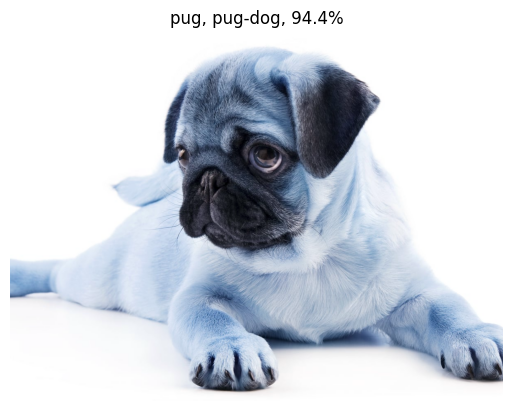

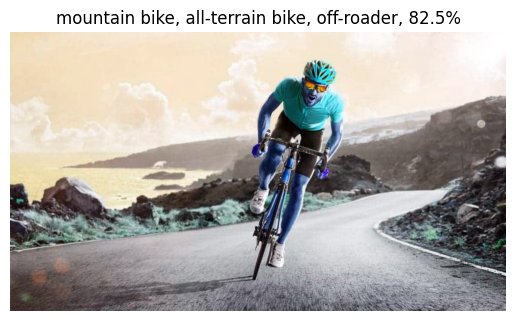

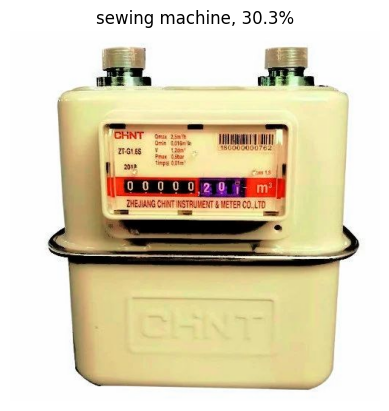

In [8]:
urls = ['https://i.guim.co.uk/img/media/fe1e34da640c5c56ed16f76ce6f994fa9343d09d/0_174_3408_2046/master/3408.jpg?width=1200&height=900&quality=85&auto=format&fit=crop&s=0d3f33fb6aa6e0154b7713a00454c83d',
        'https://lemonbin.com/wp-content/uploads/2020/06/cyclist-june172020-min.jpg',
        'https://5.imimg.com/data5/TestImages/LC/LC/YS/SELLER-18789923/domestic-diaphragm-type-gas-meter-500x500.jpg']
for url in urls:
    im = np.array(PIL.Image.open(requests.get(url, stream=True).raw))
    classify_img(im)

## CIFAR-10 minta adatok

A CIFAR-10 adatrendszer 60000 32 x 32 felbontású színes képet tartalmaz, melyeket 10 osztályba soroltak (https://www.cs.toronto.edu/~kriz/cifar.html).

Osztályok:

* repülőgép
* autó
* madár
* macska
* szarvas
* kutya
* béka
* ló
* hajó
* kamion

A Keras könyvtár segítségével hozzunk létre egy modellt.


In [9]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from pathlib import Path
from keras.models import model_from_json
from pathlib import Path
from keras.preprocessing import image
import numpy as np

Töltsük le a minta képeket és nézzünk meg néhány véletlenszerűen képet.

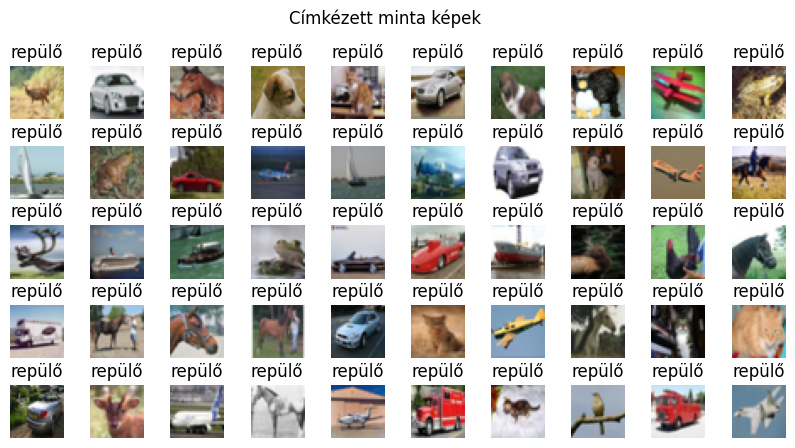

In [13]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
class_labels = [
    "repülő", # 0
    "autó",      # 1
    "madár",     # 2
    "macska",      # 3
    "szarvas",     # 4
    "kutya",      # 5
    "béka",     # 6
    "ló",    # 7
    "hajó",     # 8
    "kamion"     # 9
]
num_classes = len(class_labels)

rows = 5; cols = 10
rand_ind = np.random.randint(0, high=1000, size=rows*cols, dtype=int)
fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
fig.suptitle('Címkézett minta képek')
axes = axes.ravel()

for i in np.arange(0, rows*cols):
    img_ind = rand_ind[i]
    axes[i].imshow(x_test[img_ind])
    axes[i].set_title(class_labels[np.argmax(y_test[img_ind])])
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

Hozzuk létre a modellünket és tanítsuk be a CIFAR-10 adatkészlet felhasználásával. Ez kb. néhány percet vesz igénybe.

Kétszer 32 darab, kétszer 64 darab és kétszer 128 darab 3 x 3-as konvolúciós szűrőt és egy rejtett réteget tartalmaz a modell




In [14]:
%%time
# minta képek betöltése
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# képek normalizálása a 0-1 tartományba
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Osztály címkék konvertálása bináris osztály mátrixá
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

"""
# modell létrehozása és rétegek hozzáadása
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train the model
hist = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_test, y_test), shuffle=True)
"""
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 20
history = model.fit(x_train, y_train, batch_size=64, epochs=epochs, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/20
782/782 [==============================] - 21s 14ms/step - loss: 1.7476 - accuracy: 0.4003 - val_loss: 1.5458 - val_accuracy: 0.4666
Epoch 2/20
782/782 [==============================] - 10s 12ms/step - loss: 1.1892 - accuracy: 0.5740 - val_loss: 0.9308 - val_accuracy: 0.6644
Epoch 3/20
782/782 [==============================] - 10s 13ms/step - loss: 0.9933 - accuracy: 0.6499 - val_loss: 0.9781 - val_accuracy: 0.6471
Epoch 4/20
782/782 [==============================] - 11s 14ms/step - loss: 0.8874 - accuracy: 0.6872 - val_loss: 0.8855 - val_accuracy: 0.6910
Epoch 5/20
782/782 [==============================] - 10s 13ms/step - loss: 0.8109 - accuracy: 0.7195 - val_loss: 0.8182 - val_accuracy: 0.7111
Epoch 6/20
782/782 [==============================] - 10s 13ms/step - loss: 0.7531 - accuracy: 0.7395 - val_loss: 0.6815 - val_accuracy: 0.7669
Epoch 7/20
782/782 [==============================] - 10s 13ms/step - loss: 0.7116 - accuracy: 0.7541 - val_loss: 0.8479 - val_accuracy:

Modell pontosság:88.7%
Teszt  pontosság:82.8%


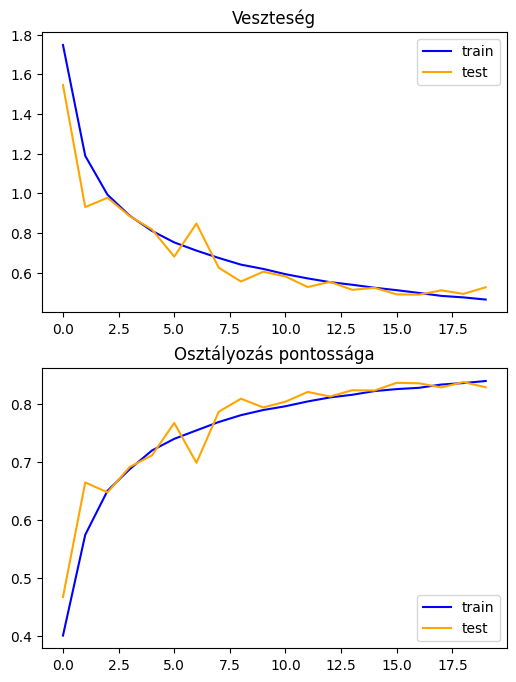

In [15]:
score, acc = model.evaluate(x_train, y_train, batch_size=64, verbose=0)
print(f'Modell pontosság:{acc:.1%}')
score, acc = model.evaluate(x_test, y_test, batch_size=64, verbose=0)
print(f'Teszt  pontosság:{acc:.1%}')
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].set_title('Veszteség')
ax[0].plot(history.history['loss'], color='blue', label='train')
ax[0].plot(history.history['val_loss'], color='orange', label='test')
ax[0].legend()
ax[1].set_title('Osztályozás pontossága')
ax[1].plot(history.history['accuracy'], color='blue', label='train')
ax[1].plot(history.history['val_accuracy'], color='orange', label='test')
ax[1].legend(loc=4)
plt.subplots_adjust(wspace=0.5)

313/313 [==============================] - 1s 2ms/step


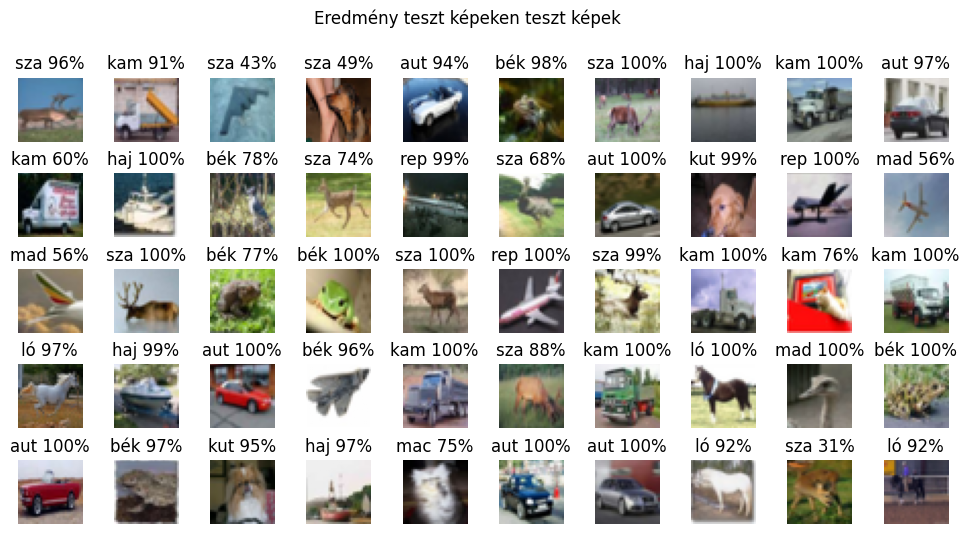

In [16]:
y_pred = model.predict(x_test)
rows = 5; cols = 10
rand_ind = np.random.randint(0, high=10000, size=rows*cols, dtype=int)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.2, rows * 1.2))
fig.suptitle('Eredmény teszt képeken teszt képek')
axes = axes.ravel()

for i in np.arange(0, rows*cols):
    img_ind = rand_ind[i]
    axes[i].imshow(x_test[img_ind])
    k = np.argmax(y_pred[img_ind])
    axes[i].set_title(f"{class_labels[k][:3]} {y_pred[img_ind, k]:.0%}")
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

Próbáljuk ki a modellt eddig nem használt képeken!

In [37]:
# add more images here from the ten classes
!wget -q https://www.shutterstock.com/image-photo/forg-260nw-151350374.jpg
!wget -q https://imagestore1.blogger.hu/25_150709_854054_a2bb73f454241fc91a575ab9596916e3_e27a2a_301.jpg
!wget -q https://upload.wikimedia.org/wikipedia/commons/thumb/9/97/Female_bengal_cat_outdoor.jpg/250px-Female_bengal_cat_outdoor.jpg

In [43]:
# collecting images from local folder
import glob
images = glob.glob("*.png") + glob.glob("*.jpg")

Load images and put together in a 4D numpy array

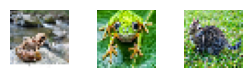

In [44]:
np_images = np.zeros((len(images), 32, 32, 3))
fig, ax = plt.subplots(1, len(images), figsize=(len(images), 1))
ax = ax.ravel()
for i, img_name in enumerate(images):
    # Load and resize to 32x32 pixels (as required by this model)
    img = image.load_img(img_name, target_size=(32, 32))
    # Convert the image to a numpy array
    np_images[i] = image.img_to_array(img)
    ax[i].imshow(img)
    ax[i].axis('off')
plt.subplots_adjust(wspace=0.5)


Making prediction from the model

In [45]:
results = model.predict(np_images)
preds = np.argmax(results, axis=1)

1/1 [==============================] - 0s 18ms/step


In [46]:
print(results)
print(preds)

[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.2272927e-34]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  3.8657583e-37 0.0000000e+00 4.3230472e-19 0.0000000e+00 2.2492995e-31]]
[1 1 1]


Output results

In [47]:
for i, pred in enumerate(preds):
    print(f"{images[i]} képen egy {class_labels[pred]} van ({results[i, pred]:.1%})")

forg-260nw-151350374.jpg képen egy autó van (100.0%)
25_150709_854054_a2bb73f454241fc91a575ab9596916e3_e27a2a_301.jpg képen egy autó van (100.0%)
250px-Female_bengal_cat_outdoor.jpg képen egy autó van (100.0%)


# Object detection with YOLO5



In [ ]:
%cd
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install

/root
Cloning into 'yolov5'...
remote: Enumerating objects: 16413, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 16413 (delta 0), reused 3 (delta 0), pack-reused 16408
Receiving objects: 100% (16413/16413), 14.90 MiB | 25.09 MiB/s, done.
Resolving deltas: 100% (11265/11265), done.
/root/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.1/610.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.9/715.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 4.9 MB/s et

In [ ]:
import glob
import cv2
from matplotlib import pyplot as plt
import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-284-g95ebf68f Python-3.10.12 torch-2.1.0+cu121 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.4/107.7 GB disk)


In [ ]:
!wget -q -O data/images/stop.jpg https://cdn.powa.com/baderscott.com/images/wp-content/uploads/2020/06/atlanta-ga-car-accident-lawyer-running-a-stop-signal-300x200-245-critical-desktop.jpg.webp

In [ ]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/

detect: weights=['yolov5s.pt'], source=data/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-284-g95ebf68f Python-3.10.12 torch-2.1.0+cu121 CPU

100% 14.1M/14.1M [00:00<00:00, 131MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/3 /root/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 335.7ms
image 2/3 /root/yolov5/data/images/stop.jpg: 448x640 1 stop sign, 285.9ms
image 3/3 /root/yolov5/data/images/zidane.jpg: 384x640 2 persons, 2 ties, 266.8ms
Speed: 1.9ms pre-process, 296.1ms inference, 13.1ms NMS per image at shape (1, 3, 640, 640)
Results sav

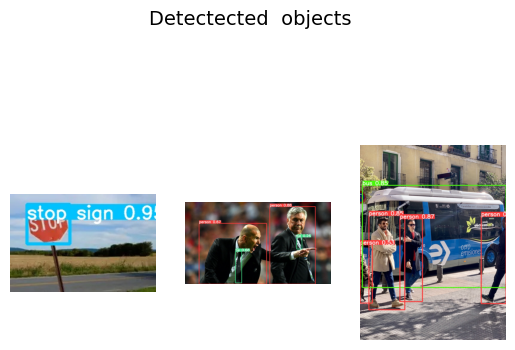

In [ ]:
# get images with detected objects and show them
im_list = glob.glob('runs/detect/exp/*.jpg')
n = len(im_list)
fig, axes = plt.subplots(1, n)
fig.suptitle('Detectected  objects', fontsize=14)
for i in range(n):
    im = cv2.imread(im_list[i])
    axes[i].imshow( cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')